# Import Libraries

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from keras import layers
from keras import models
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

plt.rcParams["figure.figsize"] = (20,8)

[nltk_data] Downloading package punkt to /Users/valtervar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/valtervar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/valtervar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Additional Preprocessing

In [23]:
# Import all excel files with data
df_1 = pd.read_excel('Data/NLP_Task.xlsx', index_col = 'Unnamed: 0')
df_2 = pd.read_excel('Data/NLP_Task_2.xlsx', index_col = 'Unnamed: 0')
df_3 = pd.read_excel('Data/NLP_Task_3.xlsx', index_col = 'Unnamed: 0')

# Concat excel files into 1 dataframe
df = pd.concat([df_1, df_2, df_3]).reset_index(drop = True)
df

,Review,Score
0,опыт взаимодействие с разный банк более год са...,1
1,обратиться в банк в отделение в нижний новгоро...,1
2,у банк открытие быть продукт виртуальный котор...,1
3,добрый время сутки хотеть поделиться свой опыт...,1
4,в период всеобщий ажиотаж и паника из за санкц...,1
...,...,...
4973,цб рф генеральный прокуратура и иной орган кот...,0
4974,смотреть по отзыв тут уже много такой но я пря...,0
4975,февраль заказать денежный средство валюта на м...,0
4976,иметь задолженность по кредитный карта долг пр...,0


In [25]:
# Check max amd min length of reviews
review_max_length = 0
review_min_length = np.inf

for i in df.Review:
    if len(i) > review_max_length:
        review_max_length = len(i)
    if len(i) < review_min_length:
        review_min_length = len(i)

print('Maximum review length:', review_max_length)
print('Minimum review length:', review_min_length)
print('Number of reviews:', df.shape[0])

Maximum review length: 3468
Minimum review length: 157
Number of reviews: 4978


In [29]:
# Get rid of stop-words
stop_words = stopwords.words('russian')

def clean_stop_words(text):
    text = word_tokenize(text)
    text = [word for word in text if word not in stop_words]
    return ' '.join(text)

df['Review'] = df['Review'].apply(lambda x: clean_stop_words(x))

review_max_length = 0
review_min_length = np.inf

for i in df.Review:
    if len(i) > review_max_length:
        review_max_length = len(i)
    if len(i) < review_min_length:
        review_min_length = len(i)

print('Maximum review length:', review_max_length)
print('Minimum review length:', review_min_length)
print('Number of reviews:', df.shape[0])

Maximum review length: 2825
Minimum review length: 135
Number of reviews: 4978


In [30]:
# Finally, mix data in dataframe
df = df.sample(frac=1).reset_index(drop=True)
df

,Review,Score
0,очень заслужить честной негатив адрес тб пробл...,1
1,решить закрыть цифровой карта мир приложение с...,0
2,хотеть выразить благодарность сотрудник банк с...,1
3,хотеть поблагодарить отметить работа заведоват...,1
4,выражать глубокий благодарность сотрудник банк...,1
...,...,...
4973,добрый день сегодня посетить мтс банк перевыпу...,1
4974,оказывать услуга самозанятой проектирование эл...,0
4975,добрый день год назад получить дебетовка польз...,1
4976,здравствовать карта срок хотеть перевыпустить ...,0


# Modelling and Comparison

In [40]:
# Define functions to compare and test without hyperparameters tuning
def NN():
    model = models.Sequential()
    model.add(layers.Embedding(1000, 128, input_length = 100))
    model.add(layers.GlobalAveragePooling1D())
    model.add(layers.Dense(128, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

def LR():
    model = LogisticRegression()
    return model

def RF():
    model = RandomForestClassifier(criterion = 'entropy')
    return model

def SVM():
    model = LinearSVC()
    return model

def XGB():
    model = xgb.XGBClassifier(verbosity = 0, use_label_encoder=False)
    return model

In [41]:
# Define train/val datasets
X = np.array(df['Review'][:4500])
y = np.array(df['Score'][:4500])

# Define test datasets
X_test = np.array(df['Review'][4500:])
y_test = np.array(df['Score'][4500:])

# Create folds for cross-validation and array with accuracy
folds = StratifiedKFold(n_splits = 10)
accuracy = []

# Loop each fold to get train and val indices
for train_index, val_index in folds.split(X_train, y_train):

    # Define train and val data
    X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]

    # Fit tokenizer via train reviews
    tokenizer = Tokenizer(num_words = 1000, oov_token = '<OOV>')
    tokenizer.fit_on_texts(X_train)
    word_index = tokenizer.word_index

    # Tokenize data through padding and max words length limitation 
    X_train = tokenizer.texts_to_sequences(X_train)
    X_train = np.array(pad_sequences(X_train, maxlen = 100, padding = 'post', truncating = 'post'))
    X_val = tokenizer.texts_to_sequences(X_val)
    X_val = np.array(pad_sequences(X_val, maxlen = 100, padding = 'post', truncating = 'post'))

    # Fit neural network
    nn = NN()
    nn.fit(X_train, y_train, epochs = 7, batch_size = 64, verbose = 0)
    nn_score = nn.evaluate(X_val, y_val, batch_size = 64, verbose = 0)[1]

    # Fit logistic regression
    lr = LR().fit(X_train, y_train)
    lr_score = lr.score(X_val, y_val)

    # Fit random forest
    rf = RF().fit(X_train, y_train)
    rf_score = accuracy_score(rf.predict(X_val), y_val)

    # Fit support vector machine
    svm = SVM().fit(X_train, y_train)
    svm_score = svm.score(X_val, y_val)

    # Fit gradient boosting
    gb = XGB().fit(X_train, y_train)
    gb_score = accuracy_score([value for value in gb.predict(X_val)], y_val)

    accuracy.append([nn_score, lr_score, rf_score, svm_score, gb_score])

accuracy_df = pd.DataFrame(accuracy, columns = ['NN', 'LR', 'RF', 'SVM', 'XGB'])
accuracy_df

/Users/valtervar/opt/anaconda3/envs/python_study/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/valtervar/opt/anaconda3/envs/python_study/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/valtervar/opt/anaconda3/envs/python_study/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/valtervar/opt/anaconda3/envs/python_study/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/valtervar/opt/anaconda3/envs/python_study/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of

,NN,LR,RF,SVM,XGB
0,0.957447,0.650456,0.680851,0.589666,0.674772
1,0.929878,0.673780,0.707317,0.500000,0.655488
2,0.935976,0.643293,0.673780,0.564024,0.676829
3,0.932927,0.628049,0.667683,0.518293,0.670732
4,0.923781,0.643293,0.655488,0.500000,0.689024
5,0.920732,0.625000,0.637195,0.503049,0.640244
6,0.951219,0.692073,0.689024,0.621951,0.728659
7,0.929878,0.682927,0.710366,0.518293,0.728659
8,0.923781,0.637195,0.664634,0.506098,0.673780
9,0.893293,0.628049,0.649390,0.536585,0.664634


* As we can see, the neural network has the best accuracy in each cross-validation step. That is why we have to use neural network approach to achieve the best performance of our model. We've chosen accuracy because there is an equal number of positive and negative samples. 

# Improvement of Neural Network

In [45]:
# Let's check an average accuracy for previous NN - it will be the baseline
print('Mean baseline accuracy:', round(accuracy_df['NN'].mean(), 4))

Mean baseline accuracy: 0.9299


In [47]:
# Define the optimal number of epochs
model = models.Sequential()
model.add(layers.Embedding(1000, 128, input_length = 100))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

X = np.array(df['Review'][:4500])
y = np.array(df['Score'][:4500])

folds = StratifiedKFold(n_splits = 5)
full_history = []

for train_index, val_index in folds.split(X, y):

    X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]
    
    tokenizer = Tokenizer(num_words = 1000, oov_token = '<OOV>')
    tokenizer.fit_on_texts(X_train)
    word_index = tokenizer.word_index

    X_train = tokenizer.texts_to_sequences(X_train)
    X_train = np.array(pad_sequences(X_train, maxlen = 100, padding = 'post', truncating = 'post'))
    X_val = tokenizer.texts_to_sequences(X_val)
    X_val = np.array(pad_sequences(X_val, maxlen = 100, padding = 'post', truncating = 'post'))

    history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 10, batch_size = 64, verbose = 0)
    full_history.append(pd.DataFrame(history.history))

In [49]:
# Check mean accuracy for each epoch
full_history_df = full_history[0]

for i in full_history[1:]:
    full_history_df += i

full_history_df /= len(full_history)
full_history_df

,loss,accuracy,val_loss,val_accuracy
0,0.699706,0.697222,0.467491,0.794667
1,0.389942,0.833889,0.326651,0.864667
2,0.274899,0.889944,0.271774,0.897333
3,0.218915,0.915889,0.236064,0.913111
4,0.184860,0.931222,0.221362,0.917333
5,0.161316,0.941722,0.215998,0.920667
6,0.143867,0.948667,0.215549,0.921778
7,0.130082,0.955222,0.213664,0.922000
8,0.118442,0.959278,0.216436,0.924667
9,0.109211,0.964611,0.221422,0.923556


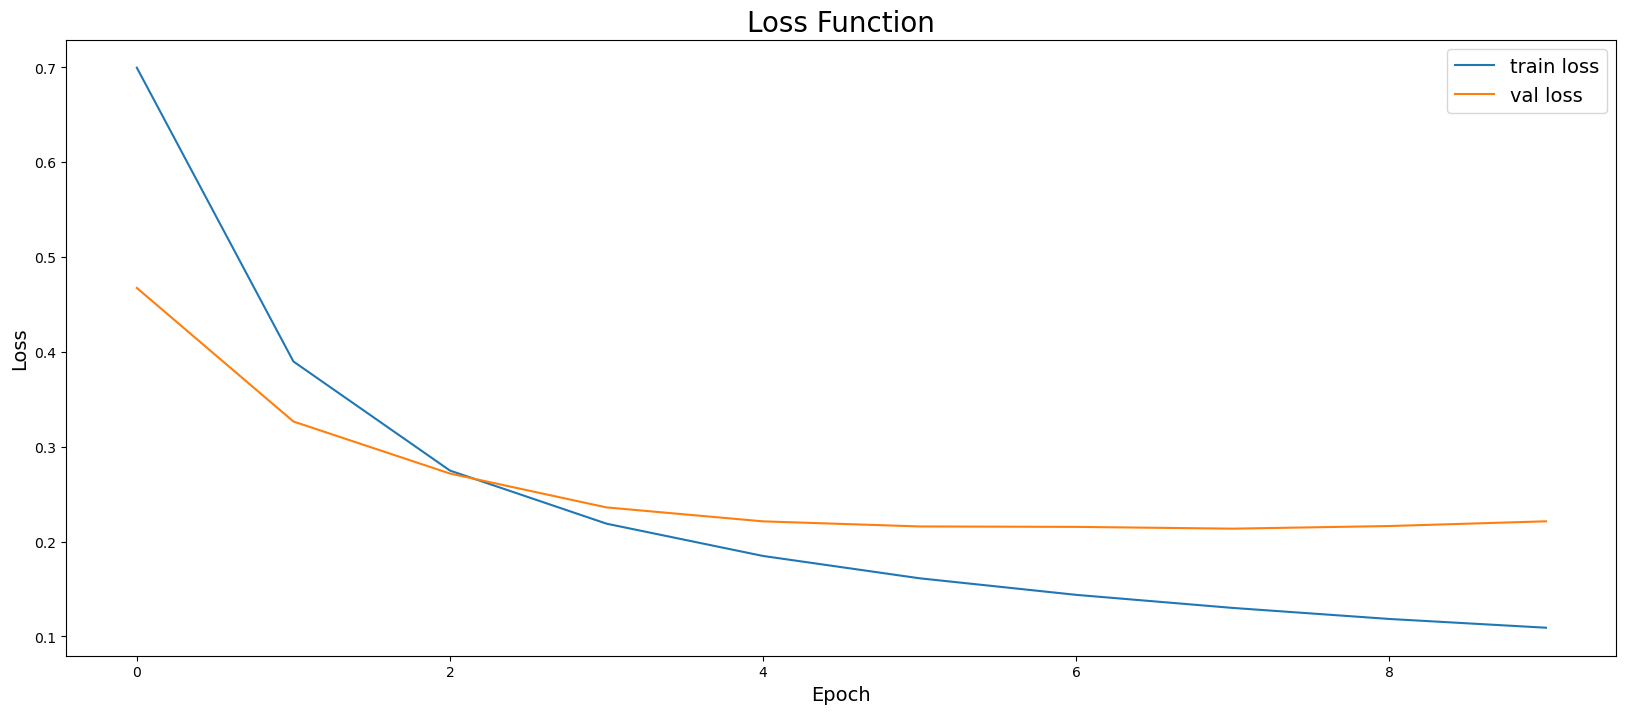

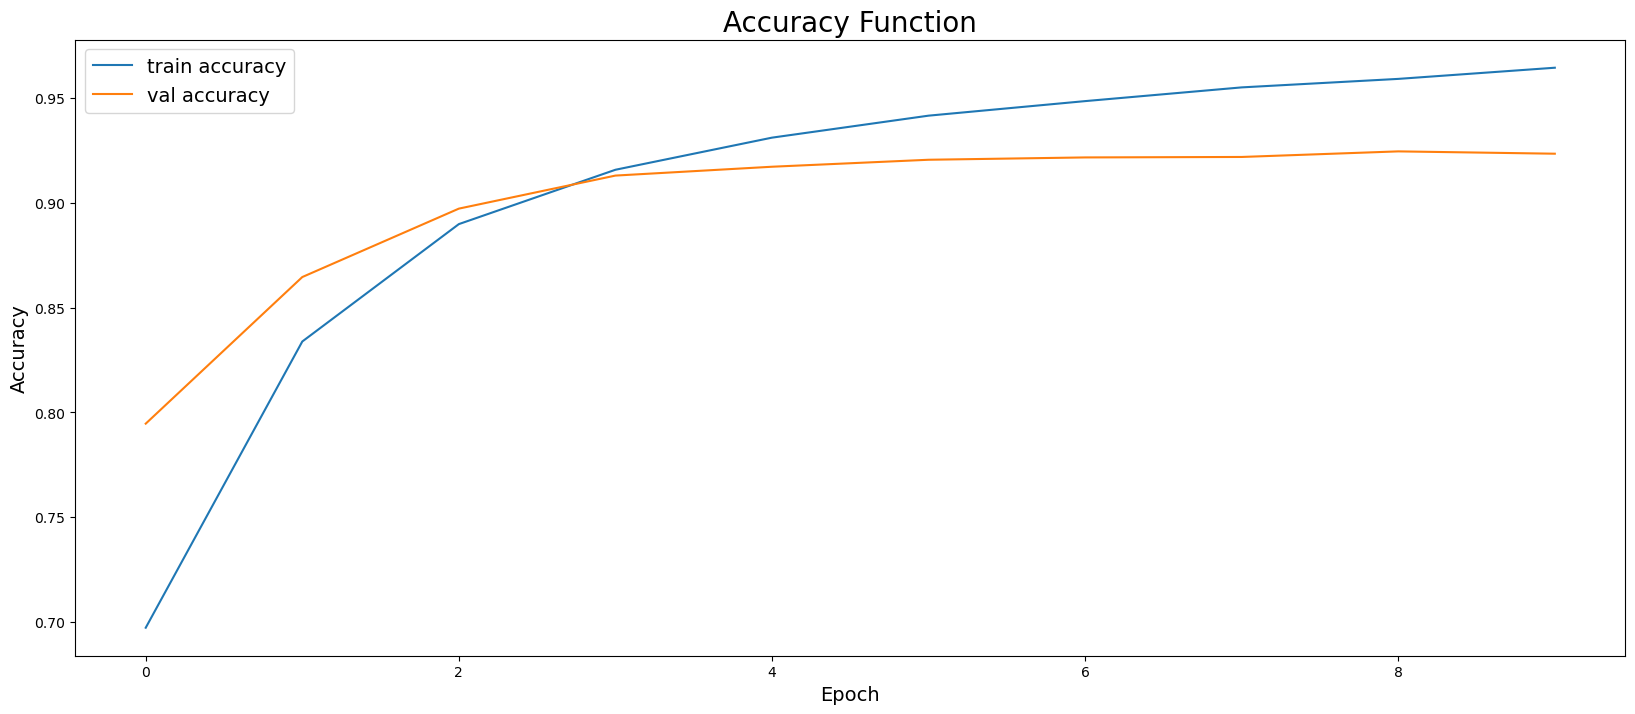

In [50]:
# Visualization
plt.plot(full_history_df.loss, label = 'train loss')
plt.plot(full_history_df.val_loss, label = 'val loss')
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
plt.title('Loss Function', fontsize = 20)
plt.legend(fontsize = 14)
plt.show()

plt.plot(full_history_df.accuracy, label = 'train accuracy')
plt.plot(full_history_df.val_accuracy, label = 'val accuracy')
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.title('Accuracy Function', fontsize = 20)
plt.legend(fontsize = 14)
plt.show()

* As we can see, there is no huge uplift to accuracy for more than 5 epochs. Let's take 5 epochs.

In [76]:
# Define the optimal number of layers
total_scores = []
for i in tqdm(range(1, 4)):
    
    if i == 1:
        model = models.Sequential()
        model.add(layers.Embedding(1000, 128, input_length = 100))
        model.add(layers.GlobalAveragePooling1D())
        model.add(layers.Dense(128, activation = 'relu'))
        model.add(layers.Dense(1, activation = 'sigmoid'))
        model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    elif i == 2:
        model = models.Sequential()
        model.add(layers.Embedding(1000, 128, input_length = 100))
        model.add(layers.GlobalAveragePooling1D())
        model.add(layers.Dense(128, activation = 'relu'))
        model.add(layers.Dense(128, activation = 'relu'))
        model.add(layers.Dense(1, activation = 'sigmoid'))
        model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    elif i == 3:
        model = models.Sequential()
        model.add(layers.Embedding(1000, 128, input_length = 100))
        model.add(layers.GlobalAveragePooling1D())
        model.add(layers.Dense(128, activation = 'relu'))
        model.add(layers.Dense(128, activation = 'relu'))
        model.add(layers.Dense(128, activation = 'relu'))
        model.add(layers.Dense(1, activation = 'sigmoid'))
        model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

    X = np.array(df['Review'][:4500])
    y = np.array(df['Score'][:4500])

    folds = StratifiedKFold(n_splits = 5)
    scores = []
    
    for train_index, val_index in folds.split(X, y):

        X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]

        tokenizer = Tokenizer(num_words = 1000, oov_token = '<OOV>')
        tokenizer.fit_on_texts(X_train)
        word_index = tokenizer.word_index

        X_train = tokenizer.texts_to_sequences(X_train)
        X_train = np.array(pad_sequences(X_train, maxlen = 100, padding = 'post', truncating = 'post'))
        X_val = tokenizer.texts_to_sequences(X_val)
        X_val = np.array(pad_sequences(X_val, maxlen = 100, padding = 'post', truncating = 'post'))

        model.fit(X_train, y_train, epochs = 5, batch_size = 64, verbose = 0)
        score = model.evaluate(X_val, y_val, batch_size = 64, verbose = 0)[1]
        scores.append(score)
    
    total_scores.append(scores)

100%|█████████████████████████████████████████████████████████████| 3/3 [00:21<00:00,  7.26s/it]


In [77]:
# Check mean accuracy for each number of dense layers
np.array(total_scores).mean(axis = 1)

array([0.91844444, 0.91866666, 0.926     ])

* We achieve better results using 3 dense layers.

In [80]:
# Check whether it's better to use dropout layers
model = models.Sequential()
model.add(layers.Embedding(1000, 128, input_length = 100))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

X = np.array(df['Review'][:4500])
y = np.array(df['Score'][:4500])

folds = StratifiedKFold(n_splits = 5)
scores = []
    
for train_index, val_index in folds.split(X, y):

    X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]

    tokenizer = Tokenizer(num_words = 1000, oov_token = '<OOV>')
    tokenizer.fit_on_texts(X_train)
    word_index = tokenizer.word_index

    X_train = tokenizer.texts_to_sequences(X_train)
    X_train = np.array(pad_sequences(X_train, maxlen = 100, padding = 'post', truncating = 'post'))
    X_val = tokenizer.texts_to_sequences(X_val)
    X_val = np.array(pad_sequences(X_val, maxlen = 100, padding = 'post', truncating = 'post'))

    model.fit(X_train, y_train, epochs = 5, batch_size = 64, verbose = 0)
    score = model.evaluate(X_val, y_val, batch_size = 64, verbose = 0)[1]
    scores.append(score)

print('Mean accuracy with dropout:', round(np.array(scores).mean(), 4))

Mean accuracy with dropout: 0.9269


In [81]:
# Tuning dense units
units = [128, 64, 32]

best_score = 0
best_i = None
best_j = None
best_z = None

for i in units:
    for j in units:
        for z in tqdm(units):
            model = models.Sequential()
            model.add(layers.Embedding(1000, 128, input_length = 100))
            model.add(layers.GlobalAveragePooling1D())
            model.add(layers.Dense(i, activation = 'relu'))
            model.add(layers.Dropout(0.5))
            model.add(layers.Dense(j, activation = 'relu'))
            model.add(layers.Dropout(0.5))
            model.add(layers.Dense(z, activation = 'relu'))
            model.add(layers.Dense(1, activation = 'sigmoid'))
            model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

            X = np.array(df['Review'][:4500])
            y = np.array(df['Score'][:4500])

            folds = StratifiedKFold(n_splits = 5)
            scores = []

            for train_index, val_index in folds.split(X, y):

                X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]

                tokenizer = Tokenizer(num_words = 1000, oov_token = '<OOV>')
                tokenizer.fit_on_texts(X_train)
                word_index = tokenizer.word_index

                X_train = tokenizer.texts_to_sequences(X_train)
                X_train = np.array(pad_sequences(X_train, maxlen = 100, padding = 'post', truncating = 'post'))
                X_val = tokenizer.texts_to_sequences(X_val)
                X_val = np.array(pad_sequences(X_val, maxlen = 100, padding = 'post', truncating = 'post'))

                model.fit(X_train, y_train, epochs = 5, batch_size = 64, verbose = 0)
                score = model.evaluate(X_val, y_val, batch_size = 64, verbose = 0)[1]
                scores.append(score)

            mean_accuracy = np.array(scores).mean()
            if mean_accuracy > best_score:
                best_score = mean_accuracy
                best_i = i
                best_j = j
                best_z = z

100%|█████████████████████████████████████████████████████████████| 3/3 [00:21<00:00,  7.12s/it]


In [82]:
print('Best score:', best_score)
print('Best first layer units:', best_i)
print('Best second layer units:', best_j)
print('Best third layer units:', best_z)

Best score: 0.9293333292007446
Best first layer units: 128
Best second layer units: 64
Best third layer units: 64


# Final Testing and Making New Observations

In [88]:
# Check model on test data
model = models.Sequential()
model.add(layers.Embedding(10000, 128, input_length = 100))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
            
X = np.array(df['Review'][:4500])
y = np.array(df['Score'][:4500])

X_test = np.array(df['Review'][4500:])
y_test = np.array(df['Score'][4500:])

tokenizer = Tokenizer(num_words = 10000, oov_token = '<OOV>')
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X)
X_train = np.array(pad_sequences(X_train, maxlen = 100, padding = 'post', truncating = 'post'))
X_test = tokenizer.texts_to_sequences(X_test)
X_test = np.array(pad_sequences(X_test, maxlen = 100, padding = 'post', truncating = 'post'))
y_train = y

model.fit(X_train, y_train, epochs = 5, batch_size = 64, verbose = 0)
print(model.evaluate(X_test, y_test))

15/15 [==============================] - 0s 992us/step - loss: 0.2571 - accuracy: 0.9331
[0.2571335732936859, 0.9330543875694275]


* We've achieved 93.3% accuracy on test data! Let's make out some new reviews: super-positive, super-negative and just positive. 

In [103]:
# Create new reviews
test = [
        'Отличный банк пользоваться год спасибо хороший работа',
        'Ужасный обслуживание ожидать нормальный сервис получить параша',
        'Принцип неплохой банк есть недостаток классный дизайн мочь рекомендовать друзья'
]

test_answers = [1, 0, 0]

test_df = pd.DataFrame({'Review': test, 'Score': test_answers})
test_df

,Review,Score
0,Отличный банк пользоваться год спасибо хороший...,1
1,Ужасный обслуживание ожидать нормальный сервис...,0
2,Принцип неплохой банк есть недостаток классный...,0


In [104]:
# Check model performance
model = models.Sequential()
model.add(layers.Embedding(10000, 128, input_length = 100))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

X = np.array(df['Review'])
y = np.array(df['Score'])

X_test = np.array(test_df['Review'])
y_test = np.array(test_df['Score'])

tokenizer = Tokenizer(num_words = 10000, oov_token = '<OOV>')
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X)
X_train = np.array(pad_sequences(X_train, maxlen = 100, padding = 'post', truncating = 'post'))
X_test = tokenizer.texts_to_sequences(X_test)
X_test = np.array(pad_sequences(X_test, maxlen = 100, padding = 'post', truncating = 'post'))
y_train = y

# Обучаем сеть и проверям точность
model.fit(X_train, y_train, epochs = 5, batch_size = 64, verbose = 0)
print(model.predict(X_test))

1/1 [==============================] - 0s 33ms/step
[[0.9987354 ]
 [0.20345403]
 [0.89705384]]


* As we can see, model detected emotional component correctly. Strictly positive review has 99.87% of probability, strictly negative - 20%, positive but not too much - 89.7%. Model performs well and is ready to be implemented for production.